# COVID Global Forecasting 

TEAM MEMBER
* Ha Dong Giang 
## Notebook Contents
[0 Introduction](#1)

[1 Data](#1)
  * [1.1 Merge original data with important features](#1.1)
  * [1.2 Merge with weather data from google cloud](#1.2)
  * [1.3 Merge with weather data from additional kaggle dataset](#1.3)

[2 Analysis](#2)
  * [2.1 Cluster Data](#2.1)
  * [2.2 Feature Extraction](#2.2)
  * [2.3 Covid Cases vs Time](#2.3)
  
[3 Prediction](#3)
  * [3.1 Baseline](#3.1)
  * [3.2 Boosting Approach](#3.2)
  * [3.3 Classifier Approach](#3.3)
  * [3.4 Bayesian Approach](#3.4)
  * [3.5 Regression Approach](#3.5)
  
[4 Conclusions](#4)
  * [4.1 Performance](#4.1)
  * [4.2 Next Steps](#4.2)

# INTRODUCTION
<a id = '0'></a>
-----
* Background and Motivation

The White House Office of Science and Technology Policy (OSTP) pulled together a coalition research groups and companies (including Kaggle) to prepare the COVID-19 Open Research Dataset (CORD-19) to attempt to address key open scientific questions on COVID-19. Those questions are drawn from National Academies of Sciences, Engineering, and Medicine’s (NASEM) and the World Health Organization (WHO).

* Problem Description

In this challenge, we will be predicting the daily number of confirmed COVID19 cases in various locations across the world, as well as the number of resulting fatalities, for future dates. This latest challenge includes US state county data.

* Data Description

First we get data from COVID19 Global Forecasting (Week 5)

 https://www.kaggle.com/c/covid19-global-forecasting-week-5/data

Current dataset are then merged with country important features dataset, (can't seem to find the link again but somewhere in the discussion thread)

Weather dataset can also be crawled from Google Bigquery, but merging them requires comparing each row of our dataset to each row of weather dataset to find the correct location and date. So we decided to just merge with other dataset from kaggle

(https://www.kaggle.com/davidbnn92/weather-data/data?scriptVersionId=31883537) 

Final dataset can be seen in Analysis section 

# Overview Of Our Process

1) We cluster each country based on their Population, Tourism, Latitude, Longtitude, Mean_Age (which can also be seen in final dataset)

2) We then compute other important features (e.g difference between First fatality reported and First confirmed date) and plot them

- Plot those important features respective to Fatality rate based on Geological location

- Plot a heat map of important features

- Plot Covid Cases vs Time respective to each country based on cluster


TODO: 

1) Run Boosting Approach, Classifier Approach, Bayesian Approach,  Regression Approach to predict the daily number of confirmed and fatalities, for future dates (tried bagging but run out of memory during training)

2) Then maybe write some thoughts on the training result and our predicts based on plots

3) Plot important features vs Time respective to some countries/regions like US, China, Asia would be nice

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import sys
# modify this
FOLDERNAME = "programming/kaggle/covid19_analysis/"
sys.path.append('/content/drive/My Drive/{}'.format(FOLDERNAME))
%cd drive/My\ Drive/$FOLDERNAME

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/programming/kaggle/covid19_analysis


In [ ]:
!pip install pycountry_convert
from IPython.display import clear_output
import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from datetime import datetime as dt
import pycountry_convert as pc
import os
%matplotlib inline
clear_output()

# 1 DATA

You don't need to run this section, as train data is extracted to train_with_weather.csv

## Merge original data with important features 

In [ ]:
dtype={'Id': np.int64,
       'Country_Region': str, 
       'Population': np.int64, 
       'Weight': np.float64, 
       'Date': str, 
       'Target': str, 
       'TargetValue': np.int64 }
df = pd.read_csv('data/train.csv', dtype=dtype)

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning:

Columns (1) have mixed types.Specify dtype option on import or set low_memory=False.



In [ ]:
df.describe()

Id    Population         Weight    TargetValue
count  969640.000000  9.696400e+05  969640.000000  969640.000000
mean   484820.500000  2.720127e+06       0.530870      12.563518
std    279911.101847  3.477771e+07       0.451909     302.524795
min         1.000000  8.600000e+01       0.047491  -10034.000000
25%    242410.750000  1.213300e+04       0.096838       0.000000
50%    484820.500000  3.053100e+04       0.349413       0.000000
75%    727230.250000  1.056120e+05       0.968379       0.000000
max    969640.000000  1.395773e+09       2.239186   36163.000000

In [ ]:
# print('Number of Target Values < 0: ', df[df.TargetValue < 0].count()['Id'])
# print('Number of NaN Values: ', end='')
# print('\n', df.isna().sum())

df = df.replace(to_replace = np.nan, value = 0) 
df.drop(df[df.TargetValue < 0].index, inplace=True)

In [ ]:
df_Confirmed_Cases=df[df["Target"]=="ConfirmedCases"]
df_Confirmed_Cases=df_Confirmed_Cases.rename(columns={"TargetValue": "ConfirmedCases"})

df_Fatalities=df[df["Target"]=="Fatalities"]
df_Fatalities=df_Fatalities.rename(columns={"TargetValue": "Fatalities"})
df=pd.merge(df_Confirmed_Cases,df_Fatalities[['Date','County','Province_State','Country_Region','Fatalities']],on=['Date','County','Province_State','Country_Region'], how='inner')
df.drop(['Target'], inplace=True, axis=1)

df["Date"] = df["Date"].map(lambda x: dt.strptime(x, '%Y-%m-%d'))
df["Year"] = df["Date"].map(lambda x: x.year)
df["Month"] = df["Date"].map(lambda x: x.month)
df = df[['Id', 'County', 'Province_State', 'Country_Region', 'Population', 'Weight', 'Date', 'Year', 'Month', 'ConfirmedCases', 'Fatalities']]

In [ ]:
dtype={'Id': np.int64,
       'Country_Region': str, 
       'Population': np.int64, 
       'Weight': np.float64, 
       'Date': str, 
       'Target': str, 
       'TargetValue': np.int64 }
features_df = pd.read_csv('data/features.csv', dtype=None)
features_df = features_df.replace(to_replace = np.nan, value = 0) 

df=pd.merge(df, features_df[['Country_Region','Tourism','Date_FirstFatality',
                         'Date_FirstConfirmedCase', 'Latitude', 'Longtitude', 'Mean_Age',
                         'Lockdown_Date', 'Lockdown_Type']],
                          on=['Country_Region'], how='left')

## Merge with weather data from google cloud

In [ ]:
from google.cloud import bigquery
from scipy.spatial.distance import cdist

# copy paste duh
# after running this, weather.csv is exported
%%time
client = bigquery.Client.from_service_account_json('covid-analysis-account.json')

dataset_ref = client.dataset("noaa_gsod", project="bigquery-public-data")
dataset = client.get_dataset(dataset_ref)

tables = list(client.list_tables(dataset))

table_ref = dataset_ref.table("stations")
table = client.get_table(table_ref)
stations_df = client.list_rows(table).to_dataframe()

table_ref = dataset_ref.table("gsod2020")
table = client.get_table(table_ref)
twenty_twenty_df = client.list_rows(table).to_dataframe()

stations_df['STN'] = stations_df['usaf'] + '-' + stations_df['wban']
twenty_twenty_df['STN'] = twenty_twenty_df['stn'] + '-' + twenty_twenty_df['wban']

cols_1 = ['STN', 'mo', 'da', 'temp', 'min', 'max', 'stp', 'slp', 'dewp', 'wdsp', 'prcp', 'fog']
cols_2 = ['STN', 'country', 'state', 'call', 'lat', 'lon', 'elev']
weather_df = twenty_twenty_df[cols_1].join(stations_df[cols_2].set_index('STN'), on='STN')

weather_df['temp'] = weather_df['temp'].apply(lambda x: np.nan if x==9999.9 else x)
weather_df['max'] = weather_df['max'].apply(lambda x: np.nan if x==9999.9 else x)
weather_df['min'] = weather_df['min'].apply(lambda x: np.nan if x==9999.9 else x)
weather_df['stp'] = weather_df['stp'].apply(lambda x: np.nan if x==9999.9 else x)
weather_df['slp'] = weather_df['slp'].apply(lambda x: np.nan if x==9999.9 else x)
weather_df['dewp'] = weather_df['dewp'].apply(lambda x: np.nan if x==9999.9 else x)
weather_df['wdsp'] = weather_df['wdsp'].apply(lambda x: np.nan if x==999.9 else x)
weather_df['prcp'] = weather_df['prcp'].apply(lambda x: np.nan if x==99.9 else x)

display(weather_df.tail(10))
weather_df.info(verbose=True)

In [ ]:
# merge weather_df with df by latitude, longtitude, compute by distance (euclidean)
from datetime import date

# read weather csv
weather_df = pd.read_csv('data/weather.csv')

# convert everything into celsius
temp = (weather_df['temp'] - 32) / 1.8
dewp = (weather_df['dewp'] - 32) / 1.8
    
# compute relative humidity as ratio between actual vapour pressure (computed from dewpoint temperature)
# and saturation vapour pressure (computed from temperature) (the constant 6.1121 cancels out)
weather_df['rh'] = (np.exp((18.678*dewp)/(257.14+dewp))/np.exp((18.678*temp)/(257.14+temp)))

# calculate actual vapour pressure (in pascals)
# then use it to compute absolute humidity from the gas law of vapour 
# (ah = mass / volume = pressure / (constant * temperature))
weather_df['ah'] = ((np.exp((18.678*dewp)/(257.14+dewp))) * 6.1121 * 100) / (461.5 * temp)

weather_df['day_from_jan_first'] = (weather_df['da'].apply(int)
                                   + 31*(weather_df['mo']=='02') 
                                   + 60*(weather_df['mo']=='03')
                                   + 91*(weather_df['mo']=='04')  
                                   + 121*(weather_df['mo']=='05')  
                                   + 152*(weather_df['mo']=='06')  
                                   ) # dataset have dates from January -> June

first_day_of_year = pd.Timestamp('2020-01-01T00')
df['Day_From_Jan_First'] = df['Date'].apply(lambda x: x-first_day_of_year)
df['Day_From_Jan_First'] = df['Day_From_Jan_First'].apply(lambda x: x.days)

C = []

# loop through each row of df, compute distance with each row of weather_df
# d = sqrt((lat_1^2 + long_1^2 + day_from_jan_first_1^2) - (lat_2^2 + long_2^2 + day_from_jan_first_2^2))
# this should took around 10-15 hours 
for j in df.index:
  temp_df = df.iloc[j:(j+1)]

  mat = cdist(temp_df[['Latitude','Longtitude', 'Day_From_Jan_First']],
              weather_df[['lat','lon', 'day_from_jan_first']], 
              metric='euclidean') # mat = array(1, 4107421)

  new_df = pd.DataFrame(mat, index=temp_df.Id, columns=weather_df.index) # new_df = dataframe(1, 4107421)
  corresponding_weather_index = new_df.idxmin(axis=1).values[0]          # min by column
  C.append(corresponding_weather_index)

df['closest_station'] = C

df = df.set_index('closest_station').join(weather_df[['temp', 'min', 'max', 'stp', 'slp', 'dewp', 'rh', 'ah', 'wdsp', 'prcp', 'fog']], ).reset_index().drop(['index'], axis=1)
df.sort_values(by=['Id'], inplace=True)
df.index = df['Id'].apply(lambda x: x-1)
df.head()

## Merge with weather data from additional kaggle dataset

In [ ]:
weather_df = pd.read_csv('data/additional_train_dataset.csv')
weather_df = weather_df.replace(to_replace = np.nan, value = 0) 
weather_df['Date'] = pd.to_datetime(weather_df['Date'])

In [ ]:
weather_df=pd.merge(weather_df, df[['Country_Region', 'Date', 'Year', 'Month', 'Tourism', 'Population','Date_FirstFatality',
                         'Date_FirstConfirmedCase', 'Mean_Age',
                         'Lockdown_Date', 'Lockdown_Type']],
                          on=['Country_Region', 'Date'], how='inner')

In [ ]:
weather_df = weather_df[['Id', 'Country_Region', 'Province_State', 'country+province', 'Lat', 'Long', 'Date', 'Year', 'Month', 'ConfirmedCases', 'Fatalities', 'Population', 'Tourism',
                   'Date_FirstFatality', 'Date_FirstConfirmedCase', 'Mean_Age', 'Lockdown_Date', 'Lockdown_Type', 'day_from_jan_first',
                   'temp', 'min', 'max', 'stp', 'slp', 'dewp', 'rh', 'ah', 'wdsp', 'prcp', 'fog']]

In [ ]:
weather_df = weather_df.rename({'Id':'Id', 'Country_Region': 'Country_Region', 'Province_State': 'Province_State', 
                        'country+province': "Country_Province", 'Lat': 'Latitude', 'Long': 'Longtitude', 
                        'Date': 'Date', 'Year': 'Year', 'Month': 'Month', 'ConfirmedCases': 'ConfirmedCases', 'Fatalities': 'Fatalities', 
                        'Date_FirstFatality': 'Date_FirstFatality', 'Date_FirstConfirmedCase': 'Date_FirstConfirmedCase', 'Mean_Age': 'Mean_Age',
                        'Lockdown_Date': 'Lockdown_Date', 'Lockdown_Type': 'Lockdown_Type', 'day_from_jan_first': 'Day_From_Jan_First',
                        "temp": "Temp", "min": "Min",
                        "max": "Max", "stp": "Stp",
                        "slp": "Slp", "dewp": "Dewp",
                        "rh": "Rh", "ah": "Ah",
                        "fog": "Fog",
                        "wdsp": "Wdsp", "prcp": "Prcp"}, axis='columns')

In [ ]:
weather_df.to_csv('data/train_with_weather.csv', index=False)

# 2 ANALYSIS

Here is the weather data description:

* temp: Mean temperature for the day in degrees Fahrenheit to tenths. 
* max: Maximum temperature reported during the day in Fahrenheit to tenths--time of max temp report varies by country and region, so this will sometimes not be the max for the calendar day. 
* min: Minimum temperature reported during the day in Fahrenheit to tenths--time of min temp report varies by country and region, so this will sometimes not be the min for the calendar day. 
* stp: Mean station pressure for the day in millibars to tenths.
* wdsp: Mean wind speed for the day in knots to tenths.
* prcp: Total precipitation (rain and/or melted snow) reported during the day in inches and hundredths; will usually not end with the midnight observation--i.e., may include latter part of previous day. .00 indicates no measurable precipitation (includes a trace).
* fog: Indicators (1 = yes, 0 = no/not reported) for the occurrence during the day
* rh: relative humidity 
* ah: absolute humidity

In [ ]:
df = pd.read_csv('data/train_with_weather.csv')

In [ ]:
# rate of fatalities
fatalities_percent_df = df.groupby('Country_Region').sum().reset_index()
x = fatalities_percent_df.Fatalities
y = fatalities_percent_df.ConfirmedCases
df['Fatality_Rate'] = (x / y) * 100

# difference betwwen first day lock down and first day Fatality
x = df['Lockdown_Date'].values.astype('datetime64')
y = df['Date_FirstFatality'].values.astype('datetime64')
df['Date_From_Fatality_To_Lockdown'] = (x - y).astype(np.int64)

# difference betwwen first day lock down and first day ConfirmedCase
x = df['Date_FirstFatality'].values.astype('datetime64')
y = df['Date_FirstConfirmedCase'].values.astype('datetime64')
df['Date_From_Confirmed_To_Fatality'] = (x - y).astype(np.int64)
df.head(10)

Id  ... Date_From_Confirmed_To_Fatality
0   2  ...                              27
1   3  ...                              27
2   4  ...                              27
3   5  ...                              27
4   6  ...                              27
5   7  ...                              27
6   8  ...                              27
7   9  ...                              27
8  10  ...                              27
9  11  ...                              27

[10 rows x 34 columns]

## 2.1 Cluster data
<a id = '2.1'></a>
-----

You also don't need to run this, as train_with_weather.csv has 'cluster' column. There are 5 clusters, based on "Population", "Tourism", "Latitude", "Longtitude", "Mean_Age"

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



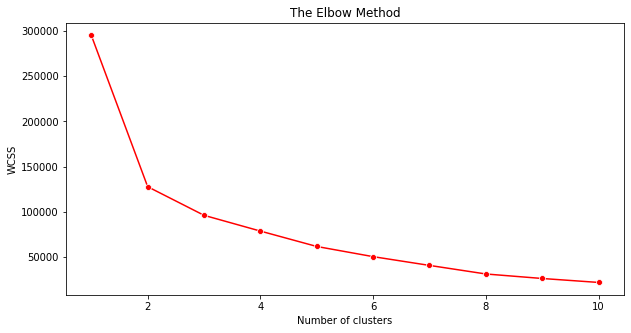

In [ ]:
# cluster data
data_to_cluster = df.copy()

data_to_cluster = data_to_cluster[["Population",
                                   "Tourism",
                                   "Latitude",
                                   "Longtitude",
                                   "Mean_Age"]]
mms.fit(data_to_cluster)
data_transformed = mms.transform(data_to_cluster)

wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state = 42)
    kmeans.fit(data_transformed)
    # inertia method returns wcss for that model
    wcss.append(kmeans.inertia_)

plt.figure(figsize=(10,5))
sns.lineplot(range(1, 11), wcss,marker='o',color='red')
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

In [ ]:
from sklearn.cluster import KMeans

In [ ]:
kmeans = KMeans(n_clusters = 5, init = 'k-means++', random_state = 42)
kmeans = kmeans.fit(data_transformed)
df['cluster'] = kmeans.labels_

## 2.2 Feature extraction
<a id = '2.2'></a>
-----

In [ ]:
import folium

country_geo = f'data/world_countries.json'

def plot_map(df, color, scatter, country_geo=country_geo):
  m = folium.Map(location=[0, 0], tiles='cartodbpositron',
                min_zoom=1, max_zoom=10, zoom_start=1.5)

  folium.Choropleth(geo_data=country_geo, data=df,
                    columns=['Country_Region', color],
                    key_on='feature.properties.name',
                    # 'BuGn', 'BuPu', 'GnBu', 'OrRd', 'PuBu', 'PuBuGn', 'PuRd', 'RdPu','YlGn', 'YlGnBu', 'YlOrBr', and 'YlOrRd'.
                    fill_color='YlOrBr', fill_opacity=0.7, line_opacity=0.1,
                    legend_name=color).add_to(m)

  for i in range(0, len(df)):
    folium.Circle(
        location=[df.iloc[i]['Latitude'], df.iloc[i]['Longtitude']],
        color='crimson', fill='crimson',
        tooltip =   '<li><bold>Country : '+str(df.iloc[i]['Country_Region'])+
                    '<li><bold>Confirmed : '+str(df.iloc[i]['ConfirmedCases'])+
                    '<li><bold>Deaths : '+str(df.iloc[i]['Fatalities'])+
                    '<li><bold>Death_rate : '+str(df.iloc[i]['Fatality_Rate'])+
                    # '<li><bold>lockdown date : '+str(df.iloc[i]['Lockdown_Date'])+
                    # '<li><bold>first case date : '+str(df.iloc[i]['Date_FirstConfirmedCase'])+
                    '<li><bold>Mean age : '+str(df.iloc[i]['Mean_Age'])+
                    '<li><bold>Tourism age : '+str(df.iloc[i]['Tourism'])
        ,
        radius=int(df.iloc[i][scatter]*10000)).add_to(m)
      
  return m
    
def plot_bar(df, col):
  pop = df.sort_values(by=col, ascending=False)[:3800]
  figure = plt.figure(figsize=(10,6))
  sns.barplot(y=pop.Country_Region, x=pop.Population)
  plt.xticks()
  plt.title('Countplot of country by ' + col)
  plt.xlabel(col)
  plt.ylabel('Country')
  plt.show()

In [ ]:
fig = px.treemap(df, path=['Country_Region'], values='ConfirmedCases',
                  color='Population', hover_data=['Country_Region'],
                  color_continuous_scale='matter', title='Current share of Worldwide COVID19 Confirmed Cases')
fig.show()

In [ ]:
fig = px.treemap(df, path=['Country_Region'], values='Fatalities',
                  color='Population', hover_data=['Country_Region'],
                  color_continuous_scale='matter', title='Current share of Worldwide COVID19 Fatalities Cases')

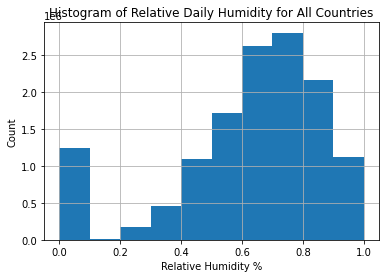

In [ ]:
df['Rh'].hist() # look only at relative_humidity column, and get histogram
# Next few lines of code set the chart title and axis labels.
plt.title('Histogram of Relative Daily Humidity for All Countries')
plt.ylabel('Count')
plt.xlabel('Relative Humidity %')
plt.show()

In [ ]:
# change the month to display map for each month
january = df[(df.Month == 1)]
january = df.groupby(["Country_Region", 
                      'Latitude', 
                      'Longtitude', 
                      'Date_From_Fatality_To_Lockdown',
                      'Date_From_Confirmed_To_Fatality',
                      'Mean_Age', 'Tourism']).agg({"ConfirmedCases":"sum","Fatalities":"sum", 'Rh': 'mean'}).reset_index()
x = january.Fatalities
y = january.ConfirmedCases
january['Fatality_Rate'] = (x / y) * 100

In [ ]:
# plot fatalities rate vs (Absolute Humidity)
plot_map(january, 'Rh', 'Fatality_Rate')

In [ ]:
# plot fatalities rate vs (fatality - confirmeddate)
plot_map(january, 'Date_From_Confirmed_To_Fatality', 'Fatality_Rate')

In [ ]:
# plot fatalities rate vs (lockdowndate - fatalitydate)
plot_map(january, 'Date_From_Fatality_To_Lockdown', 'Fatality_Rate')

In [ ]:
# plot fatalities rate vs mean age
plot_map(january, 'Mean_Age', 'Fatality_Rate')

In [ ]:
# plot fatalities rate vs tourisim
plot_map(january, 'Tourism', 'Fatality_Rate')

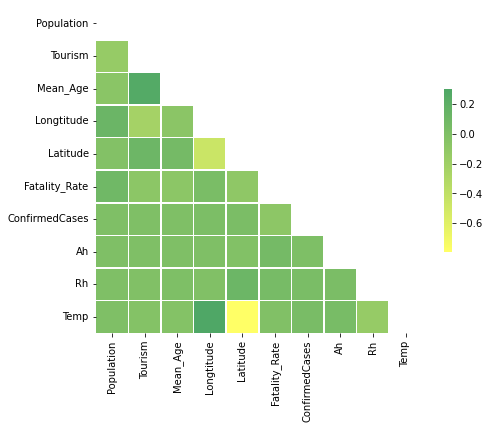

In [ ]:
# heat map
corr = df[['Population', 'Tourism', 'Mean_Age', 'Longtitude', 'Latitude', 'Fatality_Rate', 'ConfirmedCases', 'Ah', 'Rh', 'Temp']].corr()

mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
f, ax = plt.subplots(figsize=(8, 6))

sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values,mask=mask,cmap='summer_r',vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": 0.5})

## 2.3 Covid Cases vs Time
<a id = '2.3'></a>
-----

In [ ]:
plot_bar(df, 'Population')

In [ ]:
# there are 5 clusters
for cluster_index in range(5):
  temp_df = df[df['cluster'] == cluster_index]
  temp_df = temp_df[['Country_Region', 'Date', 'ConfirmedCases', 'cluster']]
  temp_df = temp_df.groupby(["Country_Region", 
                        'Date']).agg({"ConfirmedCases":"sum"}).reset_index()

  fig = px.line(temp_df, x="Date", y='ConfirmedCases', color="Country_Region", title='Total ConfirmedCases')
  fig.show()

# 3 PREDICTION

## 3.1 Baseline
<a id = '3.1'></a>
-----

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline

In [ ]:
X = df[['Day_From_Jan_First', 'Population', 'Tourism', 'Rh', 'ConfirmedCases']]
predictors = X.drop(['ConfirmedCases'], axis=1)
targets = X.drop(['Day_From_Jan_First', 'Population', 'Tourism', 'Rh'], axis=1)
X_train, X_test, y_train, y_test = train_test_split(predictors, targets, test_size = 0.22, random_state = 0)

X_train = X_train.reset_index()
X_test = X_test.reset_index()
y_train = y_train.reset_index()
y_test = y_test.reset_index()

X_train.drop(['index'], axis=1)
X_test.drop(['index'],  axis=1)
y_train.drop(['index'], axis=1)
y_test.drop(['index'],  axis=1)

X_train = X_train.to_numpy()
X_test = X_test.to_numpy()
y_train = y_train.to_numpy()
y_test = y_test.to_numpy()

model = RandomForestRegressor(n_jobs=-1)
estimators = 100
model.set_params(n_estimators=estimators)

scores = []

pipeline = Pipeline([('scaler2' , StandardScaler()),
                        ('RandomForestRegressor: ', model)])
pipeline.fit(X_train , y_train)
# prediction = pipeline.predict(X_test)

# pipeline.fit(X_train, y_train)
# scores.append(pipeline.score(X_test, y_test))

In [ ]:
plt.figure(figsize=(8,6))
plt.plot(y_test,y_test,color='deeppink')
plt.scatter(y_test,prediction,color='dodgerblue')
plt.xlabel('Actual Target Value',fontsize=15)
plt.ylabel('Predicted Target Value',fontsize=15)
plt.title('Random Forest Regressor (R2 Score= 0.95)',fontsize=14)
plt.show()

## 3.2 Boosting
<a id = '3.2'></a>
-----

## 3.3 Classifier Approach
<a id = '3.3'></a>
-----

## 3.4 Bayesian Approach
<a id = '3.4'></a>
-----

## 3.5 Regression Approach
<a id = '3.5'></a>
-----

# 4 CONCLUSIONS
<a id = '4'></a>
-----

## Covid Factors:

#### Culture: 
+ Iran and Italy: culture of kissing, hugging and handshaking

#### Politics:
+ Does a central/fedral government have the power/authority to completely isolate a province/state?
+ How quickly can a government react to the situation?
+ Is the government able to effectively allocate and move the resources to where they are needed the most in a timely manner?
+ What is the risk appetite of the goverment?

#### Weather:
+ SARS-CoV-2 survives longest when the temperature is at room temperature or lower, and when 
the relative humidity is low

## Ideas

#### Strategy of collecting data:
+ fatality/positive ratio

+ GPS tracking of whole population (using their cellphone) in at least two weeks window. 
This will create a data-set of location of individuals (infected and uninfected) in real time. 
If someone is found to be COVID-19 positive at any point of time, one can trace back all his physical 
location in last two weeks. Correlating the locations of other individuals can predict the flow 
of infection. 

## Training method: